# Dynamic Graphs and Gradient Tracking

## Backgroud and problem setting

The underlying topology is dynamic, i.e., the communication graph $\mathcal{G}^k$ changes with time/iteration $k$. This may be active or passive. 

Active case:  reduce the communication cost <br />
Passive case: the agent is moving. Mobile network or biology networks

Application: Fish vs predator example? Other ideas?

## Consensus Over Dynamic topology

Algorithm:
- Vanilla Consensus algorithm -- show not converge to true mean
- Push-sum
- Include proof sketch?

Bluefog

- `bf.neighbor_allreduce()` with neighbor_weights and send_neighbors argument
- Some pre-defined function like GetDynamicOnePeerSendRecvRanks.

## AWC/ATC + Dynamic topology


## Gradient tracking over Dynamic topology

Algorithm 
- Gradient tracking algorithm

Bluefog
- algorithm implementation



In [39]:
import bluefog.torch as bf
from bluefog.common import topology_util
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# Dynamic One Peer Strategy

When running average consensus based decentralized algorithm, the communication cost is not neglectable usually. In one round, the vector length of communication is proportional to the number of edges -- $O(E)$. Even for exponential graph each node will contain only $O(log(|V|))$ edge, the total communication cost will be $O(|V|log(|V|))$, i.e. $O(Nlog(N))$. This is actually worse than the [ring-allreduce](https://arxiv.org/pdf/1802.05799.pdf) based decentralized algorithm, which only requires $O(2N)$ communication cost. Although ring-structed neighbor allreduce will have similar communication cost, the convergence speed of ring-structure is so slow that it can hinder the gradient descent. Actually, it is shown under some assumptions that ring-allreduce algorithm actually achieve the optimal bandwidth usage for static topology.


Fortunately, AWC algorithms or other variantions also work under dynamic topology. It means in each round, the underlying topology is dynamic, i.e., the communication graph $\mathcal{G}^k$ changes with time/iteration $k$. There are many choices for generating dynamic topologies. Among them, this notebook focuses on the *dynamic one peer strategy*, which means all agents only selection one neighbor agents (peer) at each communication around. You can immediate find that the communication cost decreased to $O(N)$ now.
When it combined with Exponential graph, you will see that it not only reduces the communications cost but surprisingly accelerates the average consensus speed under mild conditions. 

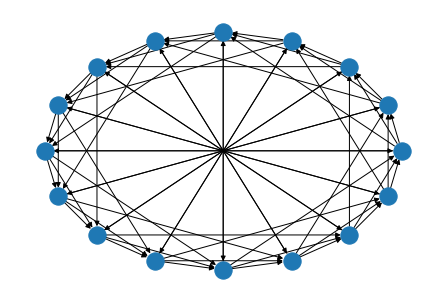

In [18]:
# Consider a static exponential-2 graph with size 16
nx.draw_circular(topology_util.ExponentialTwoGraph(16))

Under exponential-2 graph, we know the agent $i$ will send the informaiton to $[i+1, i+2, i+4, \ldots, i+2^n]$ module $N$. Then, the dynamic one peer strategy can be easily generated through at iteration $k$, agent $i$ selects the neighbro $i+2^{k\%n}$. It is easy to see that dynamic topology is periodical and the period is $n$. Let's plot the case for exponential-2 graph with size 16, which should have 4 distinct one peer graphs.

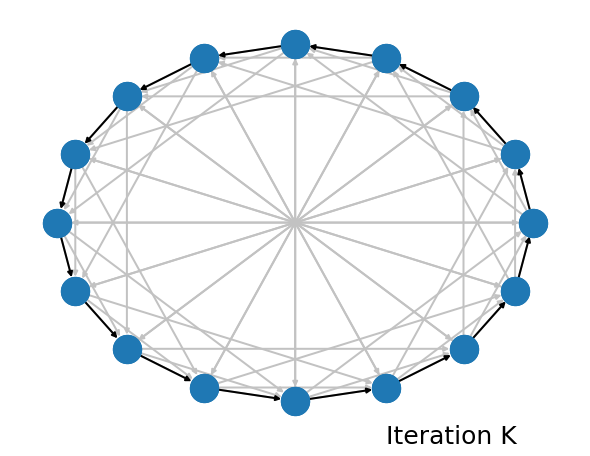

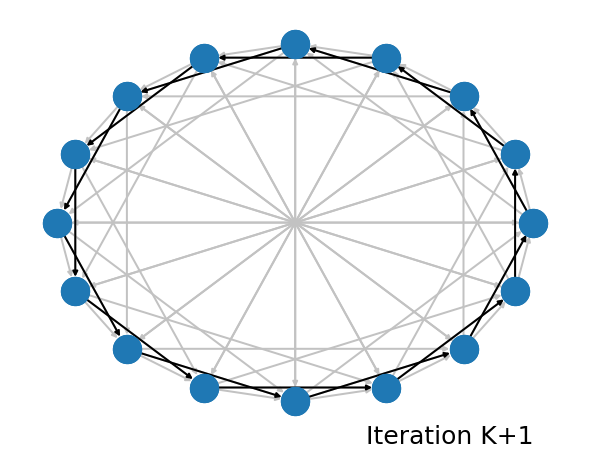

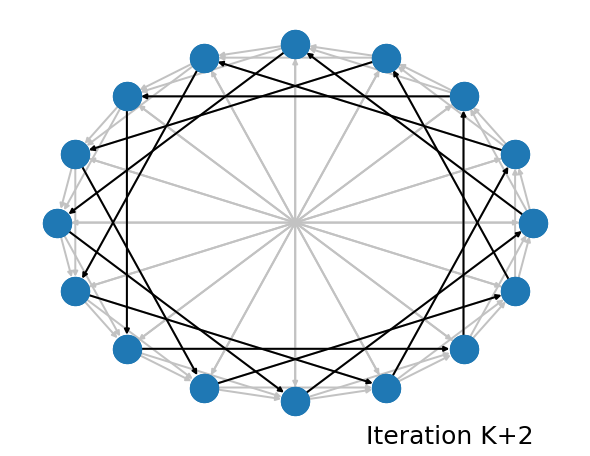

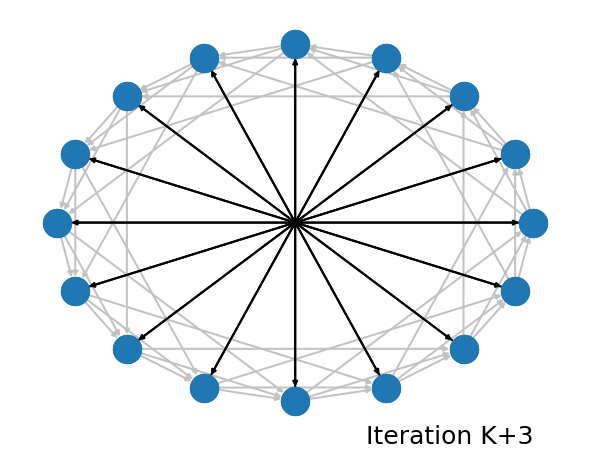

In [20]:
n = 4
size = 2 ** n
G_full = topology_util.ExponentialTwoGraph(size=size)
for k in range(4):
    plt.figure(figsize=(8, 6))
    x = np.array([1.0 if i == 2**(k%n) else 0 for i in range(size)])
    x /= x.sum()
    topo = np.empty((size, size))
    for i in range(size):
        topo[i] = np.roll(x, i)
    G = nx.from_numpy_array(topo, create_using=nx.DiGraph)

    nx.draw_circular(G_full, node_size=800, width=2, edge_color='#C2C2C2')
    nx.draw_circular(G, node_size=800, width=2)
    plt.text(1, -1.2, 'Iteration K' + ('+'+str(k) if k !=0 else '  '), horizontalalignment='right',
             verticalalignment='center', fontsize=25)
    plt.show()

It is not surprising that the communication cost is reduced. But you may wonder when we decrease the communication, will it hinder our convergence speed and eventually undermine the speedup brought by the communication? There is one simple lemma:

**Lemma** Suppose $W^{(k)}$ is the combination matrix at iteration $k$ over the dynamic one-peer exponential-2 graph with $N=2^n$ nodes. It holds that each $W^{(k)}$ is doubly-stochastic, i.e., $W^{(k)} \mathbb{1} = \mathbb{1}$ and $\mathbb{1}^T W^{(k)} = \mathbb{1}^T$. Furthermore, it holds that
\begin{align}\label{finite-time-average}
W^{(k+\ell)} W^{(k+\ell-1)} \cdots W^{(k+1)} W^{(k)}= \frac{1}{n}\mathbb{1}\mathbb{1}^T
\end{align}
for any integer $k \ge0$ and $\ell \ge n$. 

Let's verify this in code.

In [25]:
all_combined_matrix = np.eye(size)
for k in range(4):
    x = np.array([1.0 if i == 2**(k%n) else 0 for i in range(size)])
    x /= x.sum()
    topo = np.empty((size, size))
    for i in range(size):
        topo[i] = np.roll(x, i) # topo does not include self
    W = (np.eye(size) + topo) /2
    all_combined_matrix = all_combined_matrix @ W

In [33]:
uniform_matrix = np.ones([size, size]) / size
np.all(np.isclose(all_combined_matrix - uniform_matrix, 0))

True

Above lemma implies that if running average consensus under that previous case, it will converge to exact average under finite $n$ rounds.

# Average Consenus and AWC algorithms under dynamic topology

After introducing the average consensus over the dynamic one peer strategy of exponential graph, it is natural to apply that on the Adapt-With-Combine algorithm as well. It is simply just

$$
    x_{k+1,i} = \sum_{j \in \mathcal{N}_i} w^{(k)}_{ij}x_{k,j} - \alpha \nabla f_i(x_{k,i}) 
$$

noting that we change from the static weights $w_{ij}$ to dynamic $w^{(k)}_{ij}$. In order to achieve that in BlueFog, you need to specifiy the weights argument in the `neighbor_allreduce` function. Recall the full function signature is:

```
bf.neighbor_allreduce(
    tensor: torch.Tensor,
    self_weight: Union[float, NoneType] = None,
    neighbor_weights: Union[Dict[int, float], NoneType] = None,
    send_neighbors: Union[List[int], NoneType] = None,
    enable_topo_check: bool = True,
    name: Union[str, NoneType] = None,
) -> torch.Tensor
```
Different from the static case, you need to give different `self_weight`, `neighbor_weights`, and `send_neigbors` in each iteration. 

**Note:** the argument `send_neigbors`, which is the list of ranks sending to, is necessary for dynamic topology.

Since the design of BlueFog is to sperate the communication functionality from the topology usage, you need to explicitly to create these arguments for the `neighbor_allreduce` function. The code can be boilerplate and not straight-forward to write. Hence, we provide several topology utility functions for several common dynamic topology cases. Previous dynamic one peer strategy is definitely covered -- `topology_util.GetDynamicOnePeerSendRecvRanks`.

It is not a function but [generator](https://docs.python.org/3/tutorial/classes.html#generators) actually. If you are not familar with the concept of generator, don't be afraid. It is easy. Check the following example

In [43]:
def simple_generator():
    yield 1
    yield 2
    
g = simple_generator()
print(next(g))
print(next(g))

1
2


You should use the `topology_util.GetDynamicOnePeerSendRecvRanks` in a similar style. It takes the `topology` and `self_rank` as input and at each iteration, it returns two lists -- one for the ranks of sending to and another for the ranks of receiving from with respect to that `self_rank`.

In [47]:
generator = topology_util.GetDynamicOnePeerSendRecvRanks(
    topology_util.ExponentialTwoGraph(size=16), self_rank=0)
print(next(generator))
print(next(generator))
print(next(generator))
print(next(generator))
print(next(generator))

([1], [15])
([2], [14])
([4], [12])
([8], [8])
([1], [15])


With these information, you should be easy to establish the weights for the algorithms now.

Again, let's use simple average consensus algorithm to start with

In [48]:
import ipyparallel as ipp

rc = ipp.Client(profile="bluefog")

In [49]:
%%px
import torch
import bluefog.torch as bf
from bluefog.common import topology_util
bf.init()

print(f"Rank: {bf.rank()}, Size: {bf.size()}")

[stdout:0] Rank: 2, Size: 4
[stdout:1] Rank: 1, Size: 4
[stdout:2] Rank: 0, Size: 4
[stdout:3] Rank: 3, Size: 4


In [52]:
%%px
data_size = 100
seed = 1234
max_iters = 10
torch.random.manual_seed(seed * bf.rank())

x = torch.randn(data_size, dtype=torch.double)
x_bar = bf.allreduce(x, average=True)
mse = [torch.norm(x-x_bar, p=2) / torch.norm(x_bar, p=2)]

In [54]:
%%px

dynamic_neighbor_allreduce_gen = topology_util.GetDynamicOnePeerSendRecvRanks(
    bf.load_topology(), bf.rank())

for ite in range(max_iters):
    send_neighbors, recv_neighbors = next(dynamic_neighbor_allreduce_gen)
    uniform_weight = 1/(len(recv_neighbors) + 1)
    neighbor_weights = {r: uniform_weight for r in recv_neighbors}
    self_weight = uniform_weight

    x = bf.neighbor_allreduce(x, name='x', self_weight=self_weight,
                              neighbor_weights=neighbor_weights,
                              send_neighbors=send_neighbors, enable_topo_check=False)
    mse.append(torch.norm(x-x_bar, p=2) / torch.norm(x_bar, p=2))

In [55]:
mse = rc[0].pull("mse", block=True)

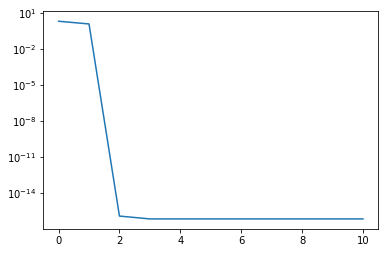

In [58]:
plt.semilogy(mse)

As shown in previous section, the algorithm will reach the consensus under `log(bf.size())` step, 